### RF over SouthernIndia [lat(10,22) lon(70,82.5)] and SST over Bay of Bengal [lat(15,21) lon(84,93.5)]

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

add_data = "/home/cccr/roxy/matin/MTech_project/data/"

In [22]:
sst

<xarray.DataArray 'analysed_sst' (time: 7670, lat: 25, lon: 39)>
array([[[27.800003, 28.100006, ..., 26.949997,       nan],
        [27.899994, 28.179993, ..., 26.949997,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[27.619995, 27.89    , ..., 27.490005,       nan],
        [27.619995, 27.899994, ..., 27.490005,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[27.199997, 27.179993, ..., 27.36    ,       nan],
        [27.100006, 27.100006, ..., 27.059998,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[26.929993, 26.949997, ..., 27.520004,       nan],
        [26.740005, 26.789993, ..., 27.289993,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01T12:00:00 ... 2018-12-31T12:00:00
  * lon      (lon) float32 84.0 84.25 84.5 84.75 85.0 ... 92.75 93.0 93.25 93.5
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
Attributes:
    standard_name:  sea_surface_foundation_temperature
    long_name:      analysed sea surface temperature
    units:          K
    source:         REMSS-L3C-TMI,REMSS-L4-MW

In [2]:
rf = xr.open_dataarray(add_data + "rfmm1_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
rf = rf[:,40:90,80:130]

sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]




# Filtering Data

In [3]:
def Butter_filter(data):
    nyquist_freq = 0.5 * 1  # Nyquist frequency (cycles/day)
    cutoff_freq_low = 1/60  # Low cutoff frequency (cycles/day)
    cutoff_freq_high = 1/30  # High cutoff frequency (cycles/day)
    order = 5  # Filter order
    b, a = butter(order, [cutoff_freq_low/nyquist_freq, cutoff_freq_high/nyquist_freq], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data
def normalize(data):
    mean = data.mean()
    std = data.std()
    normalized = (data - mean) / std
    return normalized

In [4]:
rainfall = rf
for i in range(0,50):
    for j in range(0,50):
        rainfall[:,j,i] = Butter_filter(rf[:,j,i])
filtered_sst = sst
for i in range(0,39):
    for j in range(0,25):
        filtered_sst[:,j,i] = Butter_filter(sst[:,j,i])
rainfall.to_netcdf(add_data + 'stfilteredrf.nc')
filtered_sst.to_netcdf(add_data + 'bobfilteredsst.nc')

In [5]:
rf = xr.open_dataarray(add_data + "rfmm1_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
rf = rf[:,40:90,80:130]

sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]


In [6]:
sst_mon = sst.isel(time=sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
rf_mon = rf.isel(time=rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Fsst_mon = filtered_sst.isel(time=filtered_sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Frf_mon = rainfall.isel(time=rainfall.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

# Dry and Wet Spell

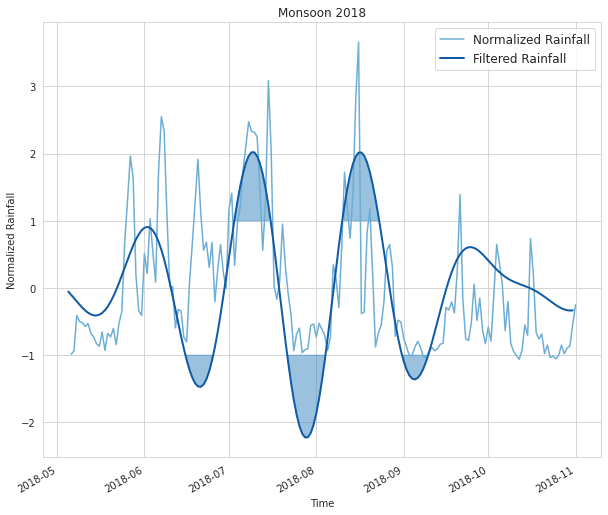

In [7]:

palette = sns.color_palette("Blues_r", n_colors=5)

plt.figure(figsize=[10,8])
sns.set_style("whitegrid")

rainfall_mean = normalize(rf.mean(dim = ['lon', 'lat'])[-240:-60])

xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"]).plot(color = palette[2], label='Normalized Rainfall')

rainfall_mean = normalize(Frf_mon.mean(dim = ['lon', 'lat'])[-180:])
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
filtered_rf.plot(color = palette[0], label='Filtered Rainfall', linewidth=2)

x = filtered_rf.time.data
y = filtered_rf.data
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color=palette[1], alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color=palette[1], alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Normalized Rainfall')
plt.title('Monsoon 2018')

plt.rcParams.update({'font.size': 14})
plt.legend(fontsize=12)

#plt.savefig('rfDry_wetSpell.png', dpi=300)

plt.show()


# Hot and Cold phase

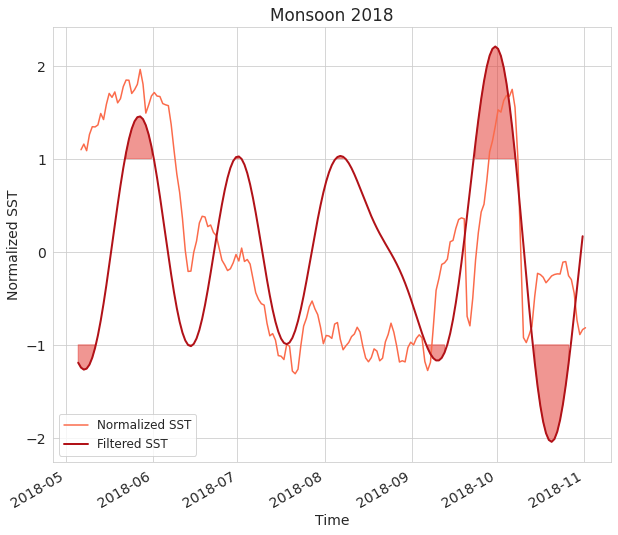

In [8]:

palette = sns.color_palette("Reds_r", n_colors=5)

plt.figure(figsize=[10,8])
sns.set_style("whitegrid")

sst_mean = normalize(sst.mean(dim = ['lon', 'lat'])[-240:-60])

xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"]).plot(color = palette[2], label='Normalized SST')

sst_mean = normalize(Fsst_mon.mean(dim = ['lon', 'lat'])[-180:])
filtered_sst = xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"])
filtered_sst.plot(color = palette[0], label='Filtered SST', linewidth=2)

x = filtered_sst.time.data
y = filtered_sst.data
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color=palette[1], alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color=palette[1], alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Normalized SST')
plt.title('Monsoon 2018')

plt.rcParams.update({'font.size': 14})
plt.legend(fontsize=12)

#plt.savefig('rfDry_wetSpell.png', dpi=300)

plt.show()


## Monsoon 2018 - Filtered Rainfall and SST Data

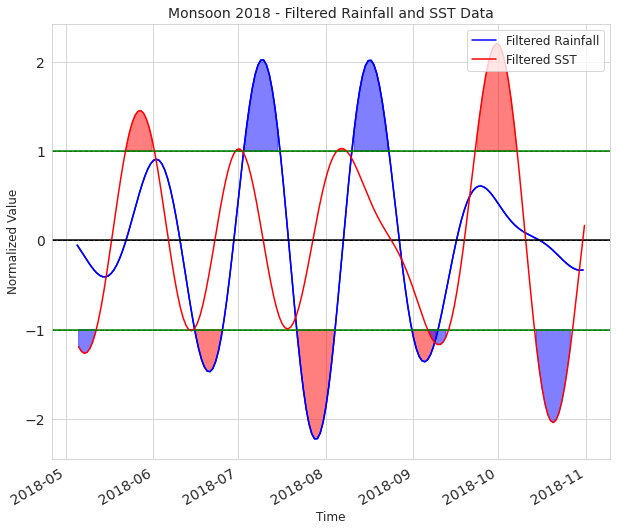

In [9]:
plt.figure(figsize=[10,8])

# Plot filtered rainfall data
rainfall_mean = normalize(Frf_mon.mean(dim = ['lon', 'lat'])[-180:])
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='Filtered Rainfall')
sns.lineplot(x=x, y=y, color='b')
plt.axhline(y=0, color='black')
plt.axhline(y=1, color='g')
plt.axhline(y=-1, color='g')
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color='blue', alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color='red', alpha=0.5)


# Plot filtered SST data
sst_mean = normalize(Fsst_mon.mean(dim = ['lon', 'lat'])[-180:])
filtered_sst = xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"])
x = filtered_sst.time.data
y = filtered_sst.data
filtered_sst.plot(color = 'r', label='Filtered SST')

# Add horizontal lines and fill color between them
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=1, color='g', linestyle='--', linewidth=1)
plt.axhline(y=-1, color='g', linestyle='--', linewidth=1)
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color='red', alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color='blue', alpha=0.5)

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title("Monsoon 2018 - Filtered Rainfall and SST Data", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
#plt.savefig("Dry_wetSpell.png")


# Correlation

In [10]:
filtered_rf = xr.open_dataarray(add_data + "stfilteredrf.nc")
filtered_sst = xr.open_dataarray(add_data + "bobfilteredsst.nc")


In [11]:
def corr(rainfall, filtered_sst, lag_days):
    filter_rf_box = rainfall[365:-365+lag_days,:,:]
    filter_rf_box_mean = filter_rf_box.mean(dim = ['lon', 'lat'])
    filter_sst_box = filtered_sst[365-lag_days:-365,:,:]
    filter_sst_box_mean = filter_sst_box.mean(dim = ['lat', 'lon'])
    return np.corrcoef(filter_rf_box_mean,filter_sst_box_mean )[0][1]
    
corr(rainfall, filtered_sst, 5)   

0.5803164657069512

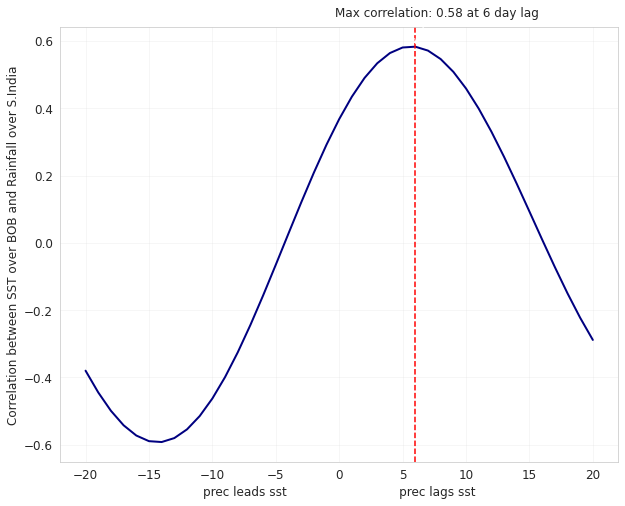

In [12]:
# Calculate correlations for different lags
lags = range(-20, 21)
corrs = [corr(rainfall, filtered_sst, lag) for lag in lags]

# Find the lag with maximum correlation
max_corr = max(corrs)
max_lag = lags[corrs.index(max_corr)]

# Plot the correlations
plt.figure(figsize=[10,8])
plt.plot(lags, corrs, linewidth=2, color='navy')
plt.axvline(x=max_lag, color='red', linestyle='--')
plt.annotate(f"Max correlation: {max_corr:.2f} at {max_lag} day lag", 
             xy=(max_lag, max_corr), xycoords='data',
             xytext=(-80, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.2"),
             fontsize=12)
plt.xlabel("prec leads sst                             prec lags sst", fontsize=12)
plt.ylabel("Correlation between SST over BOB and Rainfall over S.India", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
#plt.savefig("CorrBOByr.png")
plt.show()


# JJAS Correlation

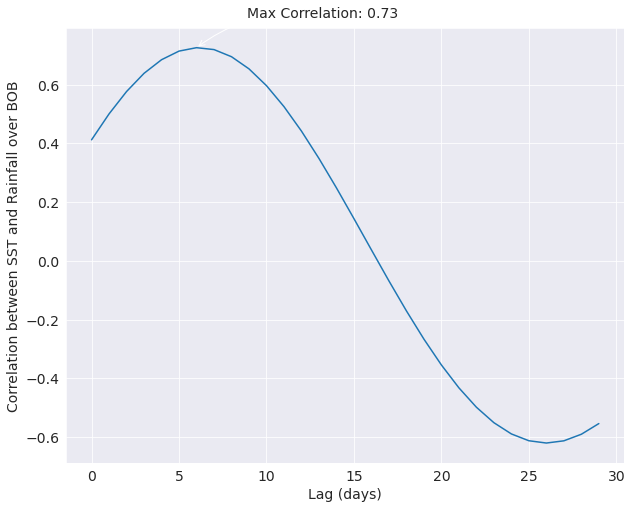

In [13]:
import seaborn as sns

# Function to calculate correlation between rainfall and filtered SST
def corr(rainfall, filtered_sst, lag_days):
    Fsst_mon = filtered_sst.isel(time=filtered_sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
    Frf_mon = rainfall.isel(time=rainfall.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
    Fsst_meam = Fsst_mon.mean(dim = ['lon', 'lat'])
    Frf_meam = Frf_mon.mean(dim = ['lon', 'lat'])
    Csst = []
    for i in range(0,3864,184):
        Csst.extend(Fsst_meam[31-lag_days+i:153-lag_days+i].data)
    Crf = []
    for i in range(0,3864,184):
        Crf.extend(Frf_meam[31+i:153+i].data)

    return np.corrcoef(Csst, Crf)[0][1]

# Calculate correlation for various lag days
corrs = [corr(rainfall, filtered_sst, i) for i in range(0,30)]

# Plot the results using Seaborn
sns.set_style("darkgrid")
plt.figure(figsize=[10,8])
sns.lineplot(x=range(0,30), y=corrs)
plt.xlabel("Lag (days)")
plt.ylabel("Correlation between SST and Rainfall over BOB")
#plt.title("Correlation between SST and Rainfall over BOB for various lag days")
plt.annotate(f"Max Correlation: {max(corrs):.2f}", xy=(np.argmax(corrs), max(corrs)), xycoords='data',
            xytext=(50, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2"))
#plt.savefig("Corrjjas.png")
plt.show()


# Data Prep

In [14]:
dummy_sst = xr.open_dataarray(add_data + "bobfilteredsst.nc")[:-13]
dummy_sst
dummy_sst.to_netcdf(add_data + "SIFilteredSSTBOB_13.nc")

In [15]:
dummy_rf = xr.open_dataarray(add_data + "stfilteredrf.nc")[13:]
new_time = pd.date_range(start='1998-01-01',end = '2018-12-18', freq='d')
dummy_rf = dummy_rf.assign_coords(time=new_time)
dummy_rf.to_netcdf(add_data + "SIFilteredrfBOB_13lag.nc")